## **##### 1.Importing necessary libraries**

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance



## **##### 2.Loading datasets**

In [2]:
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [3]:
#New
train_test = pd.concat([train, test], ignore_index=True)

In [220]:
#Old
#train_test=train.append(test)

In [4]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [69]:
#OLD
#train_test.loc[:,Expenses_columns]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

In [5]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

In [6]:
#OLD
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [771]:
#OLD
#train_test.Name = train_test.Name.fillna('Unknown Unknown')

In [8]:
train_test.loc[:,['Group']] = train_test.PassengerId.apply(lambda x: x[0:4] )

In [525]:
#Here I want to create handbooks to fill in informations in Cabin, VIP status, HomePlanet and Destination.
#OLD
'''guide_VIP=train_test.loc[:,['Group','VIP']].dropna().drop_duplicates('Group')
guide_Cabin=train_test.loc[:,['Group','Cabin']].dropna().drop_duplicates('Group')
guide_HomePlanet=train_test.loc[:,['Group','HomePlanet']].dropna().drop_duplicates('Group')
guide_Destination=train_test.loc[:,['Group','Destination']].dropna().drop_duplicates('Group')

In [526]:
#OLD
'''train_test=pd.merge(train_test,guide_Cabin,how="left",on='Group',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_VIP,how="left",on='Group',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_HomePlanet,how="left",on='Group',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_Destination,how="left",on='Group',suffixes=('','_y'))

In [527]:
#OLD
'''train_test.loc[:,['VIP']]=train_test.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['Destination']]=train_test.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [9]:
#NEW
train_test[['Deck', 'Number', 'Side']] = train_test['Cabin'].str.split('/', expand=True)

In [230]:
#OLD
#train_test.loc[:,['Cabin_1']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
#train_test.loc[:,['Cabin_2']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
#train_test.loc[:,['Cabin_3']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

In [10]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]
train_test['Name_key']=train_test['SecondName']+train_test['Group']

In [11]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination', ]
transported=['Transported']

In [12]:
train_test = train_test[num_cols+cat_cols+transported].copy()

In [517]:
#NEW
#modes = train_test[num_cols+cat_cols].mode().iloc[0]
#modes

In [498]:
#NEW
#train_test.fillna(modes, inplace=True)

In [518]:
#NEW
#train_test.isna().sum()

In [13]:
#OLD
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')

In [14]:
#OLD
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)

In [847]:
#NEW
#for column in cat_cols:
#     train_test[column] = pd.factorize(train_test[column])[0]

In [15]:
#OLD
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)

In [16]:
#OLD
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns=ohe.get_feature_names_out())

In [17]:
#OLD
train_test = train_test.drop(cat_cols,axis=1)

In [18]:
train_test = pd.concat([train_test,temp_train],axis=1)

In [19]:
train_test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,Transported,CryoSleep_False,CryoSleep_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.0,0.0,0.0,0.0,0.0,39.000000,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.000000,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.000000,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.000000,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.000000,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12966,17.0,847.0,0.0,10.0,144.0,1018.0,42.000000,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12967,0.0,0.0,0.0,0.0,0.0,0.0,28.771969,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,3203.0,28.771969,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [20]:
train = train_test[train_test['Transported'].notnull()].copy()

In [21]:
train.Transported =train.Transported.astype('int')

In [22]:
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [23]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [886]:
#NEW
#drop_list=['ShoppingMall','Age', 'FoodCourt']

In [24]:
#OLD
drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

In [25]:
X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

In [ ]:
# Original model from another related problem
'''rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=300,
                                  min_samples_split=14,
                                  min_samples_leaf=1,
                                  oob_score=True,
                                  max_depth=16,
                                  random_state=1,
                                  max_features='log2',
                                  n_jobs=-1)'''

In [26]:
# Optuna model
rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=446,
                                  min_samples_split=2,
                                  min_samples_leaf=7,
                                  oob_score=True,
                                  max_depth=57,
                                  random_state=1,
                                  max_features=None,
                                  n_jobs=-1)

In [ ]:
# Grid Search CV model
'''rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=500,
                                  min_samples_split=2,
                                  min_samples_leaf=10,
                                  oob_score=True,
                                  max_depth=8,
                                  random_state=1,
                                  max_features=None,
                                  n_jobs=-1)'''

In [27]:
X,y = shuffle(X,y, random_state=42)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [28]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

In [29]:
print(get_score(rf_model,X,y).mean())

0.7984670798241432


Initial score is 0.79905. Kaggle Score is 0.80102.
Removing drop list items, score becomes 0.80099. Kaggle score is 0.79728. 
Adding all columns with complex category columns being factored. Score becomes 0.80525. Kaggle score drops to 0.7887.
Only including CryoSleep and Expenses has a score of 0.73301. Kaggle score is 0.74935.

Score from optuma parameter optimization is 0.79847. Kaggle score is 0.80406. BEST SCORE. 

Score from Grid Search CV is 0.79858. Kaggle score is 0.79845.

In [30]:
rf_model.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=57, max_features=None,
                       min_samples_leaf=7, n_estimators=446, n_jobs=-1,
                       oob_score=True, random_state=1)

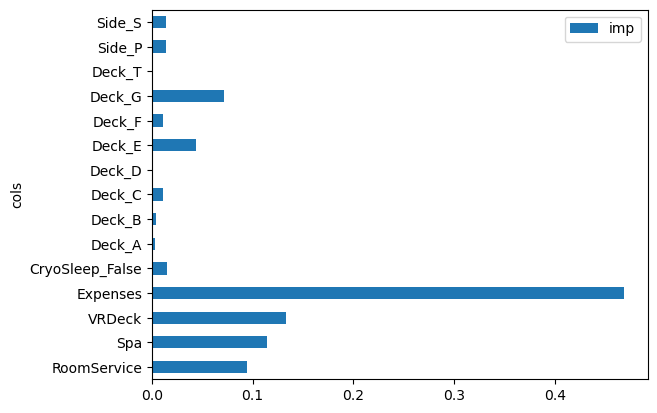

In [31]:
pd.DataFrame(dict(cols=X.columns, imp=rf_model.feature_importances_)).plot('cols', 'imp', 'barh');

## **##### 6. Submission**

In [32]:
pred_rf_best = (rf_model.fit(X,y)).predict(test)
sample['Transported'] = pred_rf_best

#This converts the numbers to True/False values
sample['Transported']=sample['Transported']>0.5
sample.to_csv('submit_rf_best_data.csv', index=False)